In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

/home/holger/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [5]:
ifd_arr87 = './Assignment_2__Input_FE/inputs_2025_Autumn_PRM/ARR87_IFDs.csv'
output_dir = './Assignment_2__Output_FE_PRM/'

catch_area = 2.4

C_10__min_contour = 0.6
C_10__max_contour = 0.8
C_10__mean_contour = 0.7

num_simulations = 1_000_000

zone = 'B' # 'A', 'B', 'C', 'D', 'E', 'F'
elevation = 'Below 500m' # 'Above 500m', 'Below 500m'

print(
    ifd_arr87,
    output_dir,
    catch_area,
    C_10__min_contour,
    C_10__max_contour,
    C_10__mean_contour,
    zone,
    elevation,
    sep='\n')

./Assignment_2__Input_FE/inputs_2025_Autumn_PRM/ARR87_IFDs.csv
./Assignment_2__Output_FE_PRM/
2.4
0.6
0.8
0.7
B
Below 500m


In [6]:
def create_output_dir(arg_output_dir):
    """create output directory if it does not exist

    arguments:
        arg_output_dir = [string] './Outputs_CM_Assignment_2/'
    """
    if not os.path.exists(arg_output_dir):
        os.makedirs(arg_output_dir)

In [7]:
create_output_dir(output_dir)

In [8]:
df_ifd = pd.read_csv(filepath_or_buffer=ifd_arr87, skiprows=2)
df_ifd['duration'] = df_ifd.DURATION.str.split(pat=' ').str[0].astype(int)
df_ifd['units'] = df_ifd.DURATION.str.split(pat=' ').str[1]
df_ifd.units = df_ifd.units.map(arg={'mins':'min', 'hours':'hr', 'hour':'hr'})
df_ifd.duration = df_ifd.apply(func=lambda arg: pd.to_timedelta(arg=arg.duration, unit=arg.units), axis=1)
df_ifd.duration = df_ifd.duration / pd.Timedelta(minutes=1)
df_ifd['duration'] = df_ifd['duration'].astype(int)
df_ifd.drop(columns=['DURATION', 'units'], inplace=True)
df_ifd.set_index(keys='duration', inplace=True)
df_ifd.columns = df_ifd.columns.astype(int)

df_ifd

,1,2,5,10,20,50,100
duration,,,,,,,
5,92.20,118.00,150.00,168.00,192.00,224.00,248.00
6,86.40,111.00,141.00,158.00,181.00,210.00,233.00
10,70.70,90.70,116.00,130.00,149.00,174.00,193.00
20,51.70,66.50,85.60,96.70,111.00,130.00,145.00
30,42.10,54.20,70.10,79.30,91.40,107.00,119.00
60,28.50,36.80,47.90,54.40,62.90,74.10,82.60
120,18.60,24.10,31.50,35.80,41.50,49.00,54.70
180,14.40,18.60,24.40,27.70,32.20,38.00,42.40
360,9.18,11.90,15.60,17.80,20.70,24.50,27.40


In [9]:
tc = 0.76*(catch_area**0.38)
tc = tc*60

tc

63.59824252533506

In [10]:
# Find the insertion point
idx = np.searchsorted(a=df_ifd.index.to_numpy(), v=tc)

# Determine the limits
if idx == 0:
    lower_limit = None
    upper_limit = df_ifd.index.to_numpy()[0]
elif idx == len(df_ifd.index.to_numpy()):
    lower_limit = df_ifd.index.to_numpy()[-1]
    upper_limit = None
else:
    lower_limit = df_ifd.index.to_numpy()[idx - 1]
    upper_limit = df_ifd.index.to_numpy()[idx]

idx = np.array(object=[lower_limit, upper_limit])
idx

array([ 60, 120])

In [11]:
I_minh_Xy = df_ifd.loc[idx.min(),:].to_numpy()
I_maxh_Xy = df_ifd.loc[idx.max(),:].to_numpy()

I_minh_Xy, I_maxh_Xy

(array([28.5, 36.8, 47.9, 54.4, 62.9, 74.1, 82.6]),
 array([18.6, 24.1, 31.5, 35.8, 41.5, 49. , 54.7]))

In [12]:
# I_1h_100y = df_ifd.loc[60,100]
# I_2h_100y = df_ifd.loc[120,100]

# I_1h_100y, I_2h_100y

In [13]:
I_catch = [np.interp(x=tc, xp=[60,120], fp=[ind1, ind2]) for ind1,ind2 in zip(I_minh_Xy, I_maxh_Xy)]
I_catch = np.array(object=I_catch)

I_catch

array([27.90628998, 36.038372  , 46.91648038, 53.28454482, 61.61662683,
       72.59473521, 80.92681723])

In [14]:
# I_catch = np.interp(x=tc, xp=[60,120], fp=[I_1h_100y,I_2h_100y])

# I_catch

In [15]:
# Mean and standard deviation
contours = np.array(object=[C_10__min_contour, C_10__max_contour])
six_sigma = 2*np.min(a=abs(contours - C_10__mean_contour))
std_dev = six_sigma / 6
contours = np.array(object=[C_10__mean_contour - 3*std_dev, C_10__mean_contour + 3*std_dev])

# Generate random points with a normal distribution
C_10 = np.random.normal(C_10__mean_contour, std_dev, num_simulations)

# Filter points to be within the desired range (0.7 to 0.8)
C_10 = C_10[(C_10 >= contours.min()) & (C_10 <= contours.max())]
C_10 = np.sort(a=C_10)

C_10

array([0.60000357, 0.60000813, 0.60002662, ..., 0.79997291, 0.79999504,
       0.79999762])

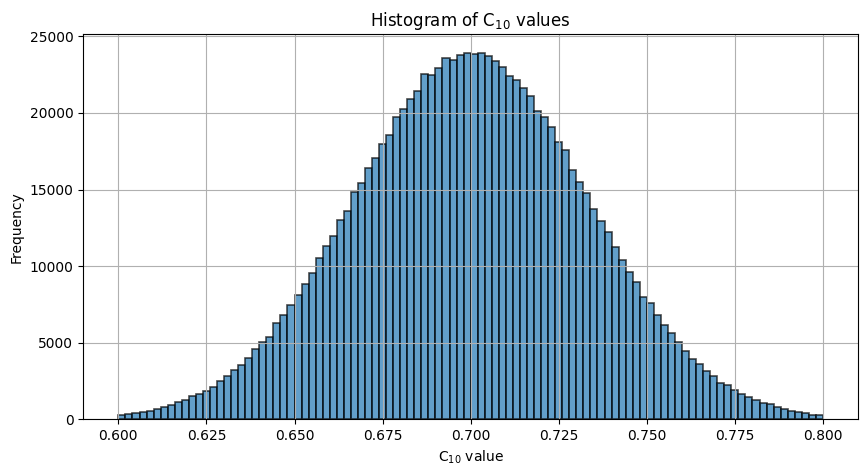

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(
    x=C_10,
    bins=100,
    color='tab:blue',
    alpha=0.7,
    edgecolor='black',
    linewidth=1.2
    );
ax.grid(visible=True)
ax.set_title(label=r'Histogram of C$_{10}$ values')
ax.set_xlabel(xlabel=r'C$_{10}$ value')
ax.set_ylabel(ylabel='Frequency')

fig.savefig(
    os.path.join(output_dir, 'C_10__histogram.png'),
    dpi=300,
    bbox_inches='tight'
)

In [17]:
I_12h_50y = df_ifd.loc[720,50]
I_12h_2y = df_ifd.loc[720,2]

I_12h_50y, I_12h_2y

(15.9, 7.69)

In [18]:
constant_50 = 0.366*I_12h_50y/I_12h_2y
constant_100 = 0.588*I_12h_50y/I_12h_2y

constant_50, constant_100

(0.7567490247074121, 1.2157607282184655)

In [19]:
if (zone == 'A') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.67, 'FF_2': 0.81, 'FF_5': 0.92, 'FF_10': 1, 'FF_20': 1.07, 
        'FF_50': 1.90 - constant_50, 
        'FF_100': 2.45 - constant_100,
        }
elif (zone == 'A') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.50, 'FF_2': 0.66, 'FF_5': 0.85, 'FF_10': 1, 'FF_20': 1.14, 
        'FF_50': 1.32, 
        'FF_100': 1.46,
        }
elif (zone == 'B') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.62, 'FF_2': 0.74, 'FF_5': 0.88, 'FF_10': 1, 'FF_20': 1.12, 
        'FF_50': 1.99 - constant_50, 
        'FF_100': 2.57 - constant_100,
        }
elif (zone == 'B') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.57, 'FF_2': 0.70, 'FF_5': 0.86, 'FF_10': 1, 'FF_20': 1.14, 
        'FF_50': 1.33, 
        'FF_100': 1.50,
        }
elif (zone == 'C') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.62, 'FF_2': 0.78, 'FF_5': 0.90, 'FF_10': 1, 'FF_20': 1.10, 
        'FF_50': 1.97 - constant_50, 
        'FF_100': 2.54 - constant_100,
        }
elif (zone == 'C') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.89, 'FF_2': 0.92, 'FF_5': 0.95, 'FF_10': 1, 'FF_20': 1.05, 
        'FF_50': 1.17, 
        'FF_100': 1.24,
        }
elif (zone == 'D') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.43, 'FF_2': 0.58, 'FF_5': 0.80, 'FF_10': 1, 'FF_20': 1.20, 
        'FF_50': 1.54, 
        'FF_100': 1.80,
        }
elif (zone == 'D') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.37, 'FF_2': 0.53, 'FF_5': 0.77, 'FF_10': 1, 'FF_20': 1.25, 
        'FF_50': 1.74, 
        'FF_100': 2.20,
        }
elif (zone == 'E') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.38, 'FF_2': 0.54, 'FF_5': 0.78, 'FF_10': 1, 'FF_20': 1.26, 
        'FF_50': 1.71, 
        'FF_100': 2.14,
        }
elif (zone == 'E') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.52, 'FF_2': 0.64, 'FF_5': 0.82, 'FF_10': 1, 'FF_20': 1.21, 
        'FF_50': 1.52, 
        'FF_100': 1.78,
        }
elif (zone == 'F') & (elevation == 'Below 500m'):
    FF_y = {
        'FF_1': 0.66, 'FF_2': 0.74, 'FF_5': 0.87, 'FF_10': 1, 'FF_20': 1.15, 
        'FF_50': 1.39, 
        'FF_100': 1.60,
        }
elif (zone == 'F') & (elevation == 'Above 500m'):
    FF_y = {
        'FF_1': 0.69, 'FF_2': 0.77, 'FF_5': 0.89, 'FF_10': 1, 'FF_20': 1.10, 
        'FF_50': 1.26, 
        'FF_100': 1.34,
        }
else:
    print('Zone and elevation not found')

FF_y

{'FF_1': 0.62,
 'FF_2': 0.74,
 'FF_5': 0.88,
 'FF_10': 1,
 'FF_20': 1.12,
 'FF_50': 1.233250975292588,
 'FF_100': 1.3542392717815344}

In [20]:
# FF_50 = 1.99 - 0.366*I_12h_50y/I_12h_2y
# FF_100 = 2.57 - 0.588*I_12h_50y/I_12h_2y

# FF_50, FF_100

In [21]:
# FF_y = {
#     'FF_1': 0.62, 
#     'FF_2': 0.74, 
#     'FF_5': 0.88, 
#     'FF_10': 1, 
#     'FF_20': 1.12,
#     'FF_50': FF_50,
#     'FF_100': FF_100,
#     }

# FF_y

In [22]:
C_y = np.array(object=[C_10*ind for ind in np.array(object=list(FF_y.values()))])

C_y

array([[0.37200222, 0.37200504, 0.3720165 , ..., 0.49598321, 0.49599693,
        0.49599853],
       [0.44400265, 0.44400602, 0.4440197 , ..., 0.59197996, 0.59199633,
        0.59199824],
       [0.52800315, 0.52800716, 0.52802343, ..., 0.70397616, 0.70399564,
        0.70399791],
       ...,
       [0.672004  , 0.67200911, 0.67202981, ..., 0.89596966, 0.89599445,
        0.89599734],
       [0.73995499, 0.73996061, 0.73998341, ..., 0.98656738, 0.98659467,
        0.98659785],
       [0.8125484 , 0.81255457, 0.81257961, ..., 1.08335474, 1.08338471,
        1.0833882 ]])

In [23]:
C_y.shape

(7, 997276)

In [24]:
C_y__stats = pd.DataFrame(data=np.transpose(a=C_y), columns=df_ifd.columns)
C_y__stats = C_y__stats.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
C_y__stats.to_csv(
    path_or_buf=os.path.join(output_dir, 'C_y__stats.csv'),
    index=True,
    header=True
)

C_y__stats

,1,2,5,10,20,50,100
count,997276.000000,997276.000000,997276.000000,997276.000000,997276.000000,997276.000000,997276.000000
mean,0.434016,0.518019,0.616023,0.700026,0.784029,0.863307,0.948002
std,0.020406,0.024356,0.028964,0.032914,0.036863,0.040591,0.044573
min,0.372002,0.444003,0.528003,0.600004,0.672004,0.739955,0.812548
5%,0.400206,0.477666,0.568035,0.645494,0.722954,0.796056,0.874154
25%,0.420124,0.501438,0.596305,0.677619,0.758934,0.835675,0.917659
50%,0.434032,0.518039,0.616046,0.700052,0.784058,0.863340,0.948038
75%,0.447954,0.534655,0.635806,0.722507,0.809208,0.891032,0.978447
95%,0.467755,0.558289,0.663911,0.754444,0.844977,0.930419,1.021698
max,0.495999,0.591998,0.703998,0.799998,0.895997,0.986598,1.083388


In [25]:
x = C_y__stats.columns.to_numpy()
y_mean = C_y__stats.loc['mean'].to_numpy()
y_05 = C_y__stats.loc['5%'].to_numpy()
y_25 = C_y__stats.loc['25%'].to_numpy()
y_50 = C_y__stats.loc['50%'].to_numpy()
y_75 = C_y__stats.loc['75%'].to_numpy()
y_95 = C_y__stats.loc['95%'].to_numpy()
y_min = C_y__stats.loc['min'].to_numpy()
y_max = C_y__stats.loc['max'].to_numpy()

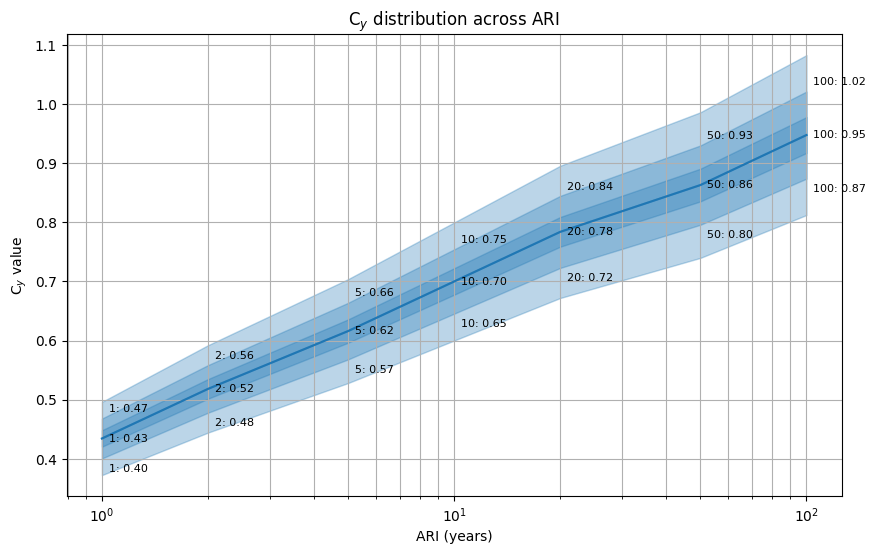

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, y_mean, color='tab:blue', label='Mean', alpha=1)
ax.plot(x, y_50, color='tab:blue', label='Median', alpha=0.3)
ax.fill_between(x=x, y1=y_min, y2=y_max, color='tab:blue', alpha=0.3)
ax.fill_between(x=x, y1=y_05, y2=y_95, color='tab:blue', alpha=0.3)
ax.fill_between(x=x, y1=y_25, y2=y_75, color='tab:blue', alpha=0.3)

for ind1, ind2 in zip(x, y_mean):
    ax.annotate(
        text='{}: {:.2f}'.format(int(ind1), ind2),
        xy=(ind1, ind2),
        xytext=(5, 0),
        textcoords='offset points',
        va='center',
        ha='left',
        fontsize=8
        )

for ind1, ind2 in zip(x, y_95):
    ax.annotate(
        text='{}: {:.2f}'.format(int(ind1), ind2),
        xy=(ind1, ind2),
        xytext=(5, 7),
        textcoords='offset points',
        va='center',
        ha='left',
        fontsize=8
        )

for ind1, ind2 in zip(x, y_05):
    ax.annotate(
        text='{}: {:.2f}'.format(int(ind1), ind2),
        xy=(ind1, ind2),
        xytext=(5, -7),
        textcoords='offset points',
        va='center',
        ha='left',
        fontsize=8
        )

ax.set_xscale(value='log')
ax.grid(which='both', axis='x')
ax.grid(axis='y')

ax.set_title(label=r'C$_y$ distribution across ARI')
ax.set_xlabel(xlabel='ARI (years)')
ax.set_ylabel(ylabel=r'C$_y$ value')

fig.savefig(
    os.path.join(output_dir, 'C_y__stats.png'),
    dpi=300,
    bbox_inches='tight'
)

In [27]:
# C100 = FF_100 * C10_value
# C100

In [28]:
Q_y = C_y*np.reshape(a=I_catch, newshape=(7,1))*catch_area/3.6

Q_y

array([[ 6.92080115,  6.9208537 ,  6.92106696, ...,  9.22736746,
         9.22762272,  9.22765245],
       [10.66742167, 10.66750267, 10.66783138, ..., 14.22266259,
        14.22305604, 14.22310186],
       [16.51469949, 16.51482488, 16.51533379, ..., 22.0187226 ,
        22.01933171, 22.01940266],
       ...,
       [27.60441329, 27.60462289, 27.60547352, ..., 36.80441895,
        36.80543709, 36.80555567],
       [35.81122456, 35.81149648, 35.8126    , ..., 47.7463983 ,
        47.74771914, 47.74787298],
       [43.83797079, 43.83830366, 43.83965453, ..., 58.4483005 ,
        58.44991739, 58.45010571]])

In [29]:
Q_y__stats = pd.DataFrame(data=np.transpose(a=Q_y), columns=df_ifd.columns)
Q_y__stats = Q_y__stats.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
Q_y__stats.to_csv(
    path_or_buf=os.path.join(output_dir, 'Q_y__stats.csv'),
    index=True,
    header=True
)

Q_y__stats

,1,2,5,10,20,50,100
count,997276.000000,997276.000000,997276.000000,997276.000000,997276.000000,997276.000000,997276.000000
mean,8.074515,12.445707,19.267740,24.867031,32.206135,41.781042,51.145866
std,0.379645,0.585168,0.905924,1.169190,1.514258,1.964448,2.404760
min,6.920801,10.667422,16.514699,21.313945,27.604413,35.811225,43.837971
5%,7.445518,11.476197,17.766800,22.929911,29.697306,38.526336,47.161649
25%,7.816068,12.047347,18.651022,24.071092,31.175288,40.443723,49.508800
50%,8.074822,12.446179,19.268471,24.867975,32.207358,41.782628,51.147807
75%,8.333826,12.845397,19.886518,25.665629,33.240427,43.122829,52.788402
95%,8.702210,13.413207,20.765570,26.800137,34.709767,45.029005,55.121829
max,9.227652,14.223102,22.019403,28.418339,36.805556,47.747873,58.450106


In [30]:
x = Q_y__stats.columns.to_numpy()
y_mean = Q_y__stats.loc['mean'].to_numpy()
y_05 = Q_y__stats.loc['5%'].to_numpy()
y_25 = Q_y__stats.loc['25%'].to_numpy()
y_50 = Q_y__stats.loc['50%'].to_numpy()
y_75 = Q_y__stats.loc['75%'].to_numpy()
y_95 = Q_y__stats.loc['95%'].to_numpy()
y_min = Q_y__stats.loc['min'].to_numpy()
y_max = Q_y__stats.loc['max'].to_numpy()

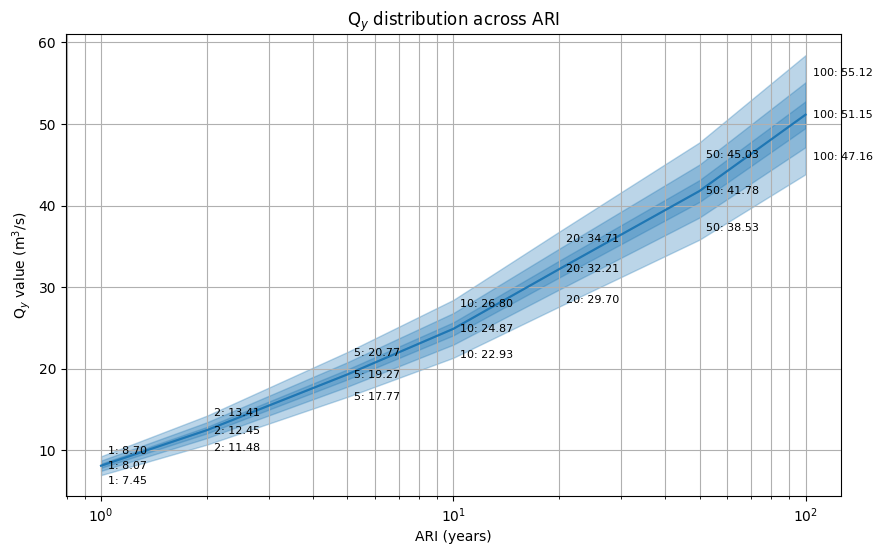

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, y_mean, color='tab:blue', label='Mean', alpha=1)
ax.plot(x, y_50, color='tab:blue', label='Median', alpha=0.3)
ax.fill_between(x=x, y1=y_min, y2=y_max, color='tab:blue', alpha=0.3)
ax.fill_between(x=x, y1=y_05, y2=y_95, color='tab:blue', alpha=0.3)
ax.fill_between(x=x, y1=y_25, y2=y_75, color='tab:blue', alpha=0.3)

for ind1, ind2 in zip(x, y_mean):
    ax.annotate(
        text='{}: {:.2f}'.format(int(ind1), ind2),
        xy=(ind1, ind2),
        xytext=(5, 0),
        textcoords='offset points',
        va='center',
        ha='left',
        fontsize=8
        )

for ind1, ind2 in zip(x, y_95):
    ax.annotate(
        text='{}: {:.2f}'.format(int(ind1), ind2),
        xy=(ind1, ind2),
        xytext=(5, 7),
        textcoords='offset points',
        va='center',
        ha='left',
        fontsize=8
        )

for ind1, ind2 in zip(x, y_05):
    ax.annotate(
        text='{}: {:.2f}'.format(int(ind1), ind2),
        xy=(ind1, ind2),
        xytext=(5, -7),
        textcoords='offset points',
        va='center',
        ha='left',
        fontsize=8
        )

ax.set_xscale(value='log')
ax.grid(which='both', axis='x')
ax.grid(axis='y')

ax.set_title(label=r'Q$_y$ distribution across ARI')
ax.set_xlabel(xlabel='ARI (years)')
ax.set_ylabel(ylabel=r'Q$_y$ value (m$^3$/s)')
fig.savefig(
    os.path.join(output_dir, 'Q_y__stats.png'),
    dpi=300,
    bbox_inches='tight'
)

In [32]:
FF_y

{'FF_1': 0.62,
 'FF_2': 0.74,
 'FF_5': 0.88,
 'FF_10': 1,
 'FF_20': 1.12,
 'FF_50': 1.233250975292588,
 'FF_100': 1.3542392717815344}

In [33]:
_inputs = {
    'Catchment Area (km^2)': catch_area,
    'C_10 min contour': C_10__min_contour,
    'C_10 max contour': C_10__max_contour,
    'C_10 mean contour': C_10__mean_contour,
    'Zone': zone,
    'Elevation': elevation,
    'tc (min)': tc,
    'tc (h)': tc/60,
    'I_12h_50y (mm)': I_12h_50y,
    'I_12h_2y (mm)': I_12h_2y,
    }
_inputs = pd.DataFrame(data=list(_inputs.values()), index=_inputs.keys(), columns=['Values'])
_inputs.index.name = 'Input Parameters'
_inputs.to_csv(
    path_or_buf=os.path.join(output_dir, '_inputs.csv'),
    index=True,
    header=True
)

_inputs

,Values
Input Parameters,
Catchment Area (km^2),2.4
C_10 min contour,0.6
C_10 max contour,0.8
C_10 mean contour,0.7
Zone,B
Elevation,Below 500m
tc (min),63.598243
tc (h),1.059971
I_12h_50y (mm),15.9


In [34]:
_calculations = np.vstack((
    I_minh_Xy, I_maxh_Xy, I_catch, 
    np.array(object=list(FF_y.values())),
    C_y__stats.loc['mean'].to_numpy(),
    Q_y__stats.loc['mean'].to_numpy(),
    ))
_calculations = pd.DataFrame(data=_calculations, index=['I_minh_Xy', 'I_maxh_Xy', 'I_catch', 'FF_y', 'C_y__mean', 'Q_y__mean'], columns=df_ifd.columns)
_calculations.to_csv(
    path_or_buf=os.path.join(output_dir, '_calculations.csv'),
    index=True,
    header=True
)

_calculations

,1,2,5,10,20,50,100
I_minh_Xy,28.500000,36.800000,47.900000,54.400000,62.900000,74.100000,82.600000
I_maxh_Xy,18.600000,24.100000,31.500000,35.800000,41.500000,49.000000,54.700000
I_catch,27.906290,36.038372,46.916480,53.284545,61.616627,72.594735,80.926817
FF_y,0.620000,0.740000,0.880000,1.000000,1.120000,1.233251,1.354239
C_y__mean,0.434016,0.518019,0.616023,0.700026,0.784029,0.863307,0.948002
Q_y__mean,8.074515,12.445707,19.267740,24.867031,32.206135,41.781042,51.145866
